### Utility function
adapted from `PyLCM_edu.ipynb`

In [52]:
def create_results_dict(
        input
    ):
    """ Returns results as a dictionary, to make it easier to compare between runs. """

    nt, dt, time_array, T_parcel_array, P_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, wp_parcel_array, \
    qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts, \
    spectra_arr, con_ts, act_ts, evp_ts, dea_ts, acc_ts, aut_ts, precip_ts, particles_array, \
    rc_liq_avg_array, rc_liq_std_array, TAU_ts_array, albedo_array = input

    results = {
        'nt': nt, 'dt': dt, 'time': time_array, 'T_parcel': T_parcel_array, 'P_parcel': P_parcel_array, 'RH_parcel': RH_parcel_array, 'q_parcel': q_parcel_array, 'z_parcel': z_parcel_array, 'wp_parcel': wp_parcel_array,
        'qa': qa_ts, 'qc': qc_ts, 'qr': qr_ts, 'na': na_ts, 'nc': nc_ts, 'nr': nr_ts,
        'spectra': spectra_arr, 'con': con_ts, 'act': act_ts, 'evp': evp_ts, 'dea': dea_ts, 'acc': acc_ts, 'aut': aut_ts, 'precip': precip_ts, 'particles': particles_array,
        'rc_liq_avg': rc_liq_avg_array, 'rc_liq_std': rc_liq_std_array, 'tau': TAU_ts_array, 'albedo': albedo_array
    }
    
    return results

### Setup model

In [53]:
# Import necessary modules
from PyLCM.animation import *
from PyLCM.widget import *
from PyLCM.timestep_routine import *
from PyLCM.parameters import *
# Import user modifiable modules
from Post_process.analysis import *
from Post_process.print_plot import *

# Uncomment lines below when changing source files
#######################
%load_ext autoreload
%autoreload 2
#######################

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
%%capture
# Model steering parameters

dt                  = 1 # s
nt                  = 10000
do_condensation     = True
do_collision        = True
switch_sedi_removal = False
n_particles         = 500
max_z               = 1400 # m


# Parcel initial parameters

T_parcel        = 289.27 # K
P_parcel        = 101181 # Pa
RH_parcel       = 0.83
w_parcel        = 1.0 # m s-1
z_parcel        = 0 # m
ascending_mode  = 'turbulent' # linear / sine / in_cloud_oscillation / turbulent

# Entrainment parameters

switch_entrainment  = False
stability           = 'Stable' # Stable / Unstable / Neutral
entrainment_start   = 1000 # s
entrainment_end     = 1030 # s
entrainment_rate    = 0.05

# Even if you are not using entrainment, you need to calculate these
qv_init = RH_parcel * esatw( T_parcel ) / ( P_parcel - RH_parcel * esatw( T_parcel ) ) * r_a / rv
qv_profiles, theta_profiles, z_env = create_env_profiles(T_parcel, qv_init, z_parcel, P_parcel, stability)

# Koehler theory

kohler_activation_radius    = True
switch_kappa_koehler        = False
mode_aero_init              = 'Random' # Random / Weighting_factor

# Initialisation parameters for aerosol (up to 4 modes)
# N_aero = number of aerosol per cm3 of air | mu = mean droplet radius | sigma = std. of mu | kappa = hygroscopicity parameter

N_aero, mu_aero, sigma_aero, k_aero = [0]*4,[0]*4,[0]*4,[0]*4

# Mode #1
N_aero[0]       = 100e6 # N_aero (m-3)
mu_aero[0]      = 0.1e-6 # mu (m)
sigma_aero[0]   = 2. # sigma (-)
k_aero[0]       = 1.0 # kappa

# Display mode

display_mode = 'text_fast' # text_fast / graphics


### Run model

In [55]:
run \
= create_results_dict(timesteps_function(
    dt, nt, do_condensation, do_collision, n_particles, \
    T_parcel, P_parcel, RH_parcel, w_parcel, z_parcel, max_z, \
    rm_spec, ascending_mode, display_mode, \
    mode_aero_init, N_aero, mu_aero, sigma_aero, k_aero, \
    kohler_activation_radius, switch_kappa_koehler, switch_sedi_removal, \
    entrainment_rate, switch_entrainment, entrainment_start, entrainment_end,
    qv_profiles, theta_profiles
))

value: Time (s) z (m)    T (K)    qv (g/kg) RH (%)   QC (g/kg) QR (g/kg) NA (/mg) NC (/mg) NR (/mg) Comp. particles
after: 1400.0    1405.89  280.44   7.54      100.108   1.694     0.271     0.45      57.85     2.85      500     


### Plots

In [56]:
# user can choice if he wants the plots time-dependent or height-dependent (except of DSD and particle densities always being time dependent)
mode_plots_widget, increment_widget, droplet_mode_widget = plot_widgets_settings(nt)

ToggleButtons(description='Plots are:', layout=Layout(width='max-content'), options=('time-series', 'vertical …

'For droplet spectra: set increment (e.g. 20: every 20th timestep a line is drawn): '

BoundedIntText(value=20, description='For droplet spectra: increment: ', max=10000, min=1, style=DescriptionSt…

ToggleButtons(description='Show only:', index=2, layout=Layout(width='max-content'), options=('Aerosol mode', …

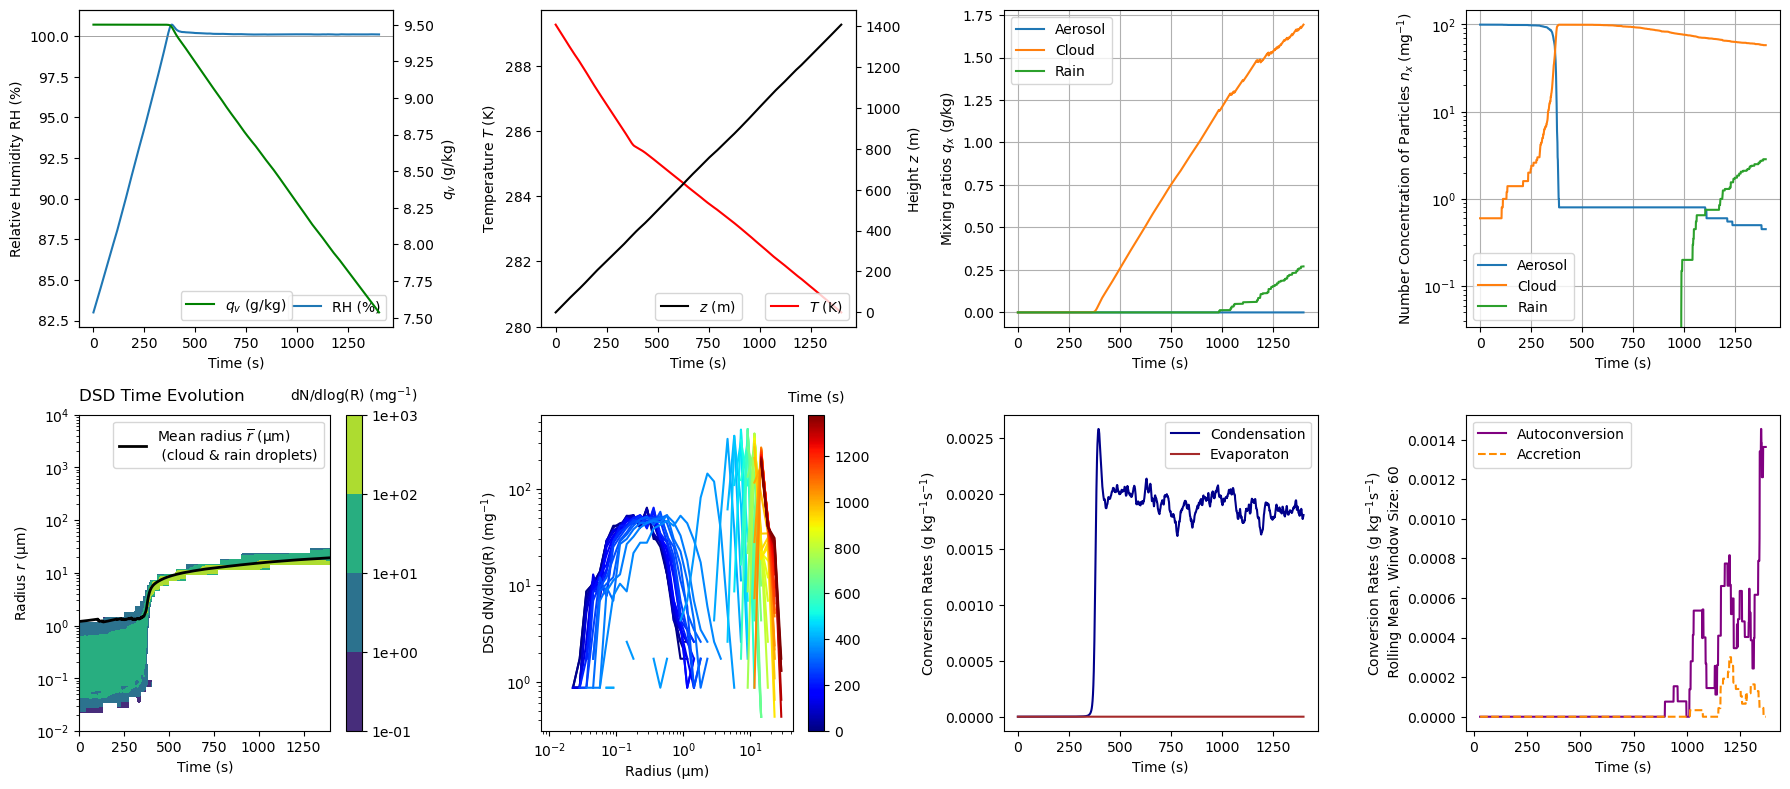

In [57]:
plot_mode = mode_plots_widget.value

subplot_array_function(
    plot_mode, dt, nt, max_z, z_parcel, w_parcel, rm_spec,
    run['qa'], run['qc'], run['qr'],
    run['na'], run['nc'], run['nr'],
    run['T_parcel'], run['RH_parcel'], run['q_parcel'], run['z_parcel'],
    run['spectra'], increment_widget, run['con'], run['act'], run['evp'],
    run['dea'], run['acc'], run['aut'], run['rc_liq_avg'],
    droplet_mode_widget.value
    )

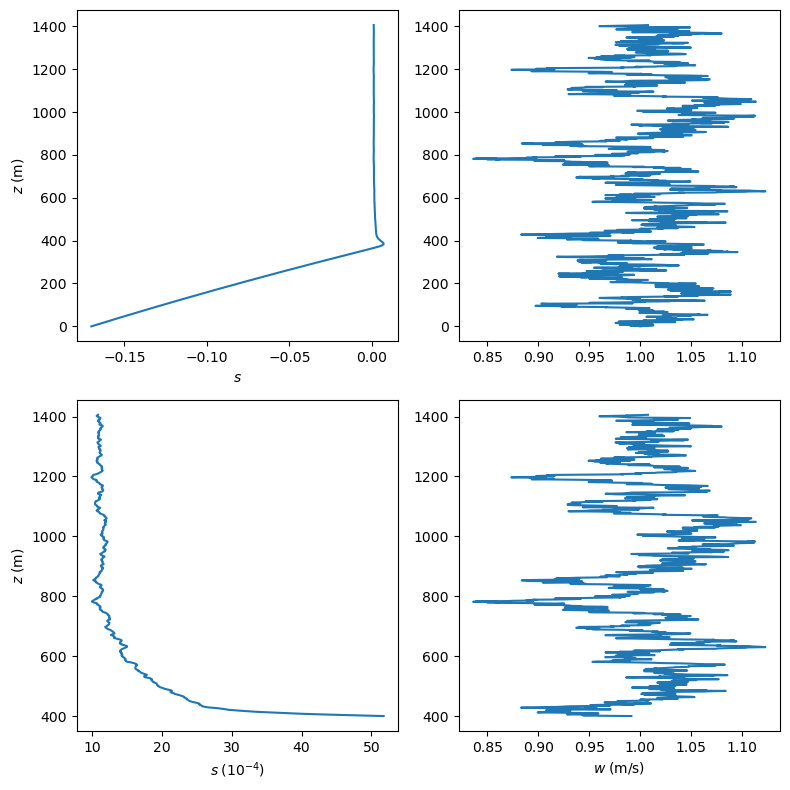

In [58]:
# Plot linear vs turbulent ascent (reference run)
fig, axs = plt.subplots(2,2,figsize=(8,8))

start_ind =0
axs[0,0].plot(run['RH_parcel']-1,run['z_parcel'])
axs[0,0].set_xlabel(r'$s$')
axs[0,0].set_ylabel(r'$z\;$(m)')

axs[0,1].plot(run['wp_parcel'] + w_parcel,run['z_parcel']) # total updraft

height = 400 
start_ind = np.abs(run['z_parcel']-height).argmin()

axs[1,0].plot((run['RH_parcel'][start_ind:]-1)/1e-4,run['z_parcel'][start_ind:],label='turbulent')
axs[1,0].set_xlabel(r'$s\;(10^{-4})$')
axs[1,0].set_ylabel(r'$z\;$(m)')

axs[1,1].plot(run['wp_parcel'][start_ind:] + w_parcel,run['z_parcel'][start_ind:],label='turbulent')
axs[1,1].set_xlabel(r'$w\;$(m/s)')

plt.tight_layout()

plt.show()